## Import Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

#!conda install -c conda-forge wordcloud
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator



Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In [4]:
!conda list matplotlib

# packages in environment at /opt/conda/envs/Python36:
#
# Name                    Version                   Build  Channel
matplotlib                3.1.1            py36h5429711_0  


## Download dataset containing New York neighborhoods

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
neighborhoods_data = newyork_data['features']

#### Transforming the data in a pandas dataframe

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

#### Looping through data to fill in the dataframe

In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

#### Examining the dataframe

In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
neighborhoods.size

1224

#### Getting latitude and longitude of New York City

In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Map of New York city with neighborhoods superimposed on top

In [11]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

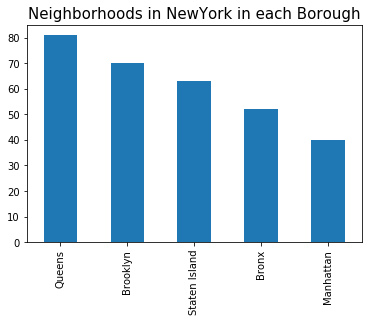

In [12]:
count=neighborhoods['Borough'].value_counts()
count.plot.bar()
plt.title('Neighborhoods in NewYork in each Borough', fontsize = 15)
plt.show()


### Now reading the excel file containting information on cuisines in different New York Neighborhoods

In [11]:
file_id='1_SZdzgSqG42giAYN37bnrPO-vGbXsgws'
link='https://drive.google.com/uc?export=download&id={FILE_ID}'

csv_url=link.format(FILE_ID=file_id)
#The final url would be as below:-
#csv_url='https://drive.google.com/uc?export=download&id=1-tjNjMP6w0RUV4GhJWw08ql3wYwsNU69'
df = pd.read_csv(csv_url,header=0)

In [14]:
df.head()

,Borough,Neighborhood,Cuisine
0,Bronx,Bedford Park,"Mexican, Peurto Rican, Dominican, Korean"
1,Bronx,Belmont,"Italian, Albanian"
2,Bronx,City Island,"Italian, Seafood"
3,Bronx,Morris Park,"Italian, Albanian"
4,Bronx,Norwood,Filipino


In [15]:
def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]

def split_df(dataframe, col_name, sep):
    orig_col_index = dataframe.columns.tolist().index(col_name)
    orig_index_name = dataframe.index.name
    orig_columns = dataframe.columns
    dataframe = dataframe.reset_index()  # we need a natural 0-based index for proper merge
    index_col_name = (set(dataframe.columns) - set(orig_columns)).pop()
    df_split = pd.DataFrame(
        pd.DataFrame(dataframe[col_name].str.split(sep).tolist())
        .stack().reset_index(level=1, drop=1), columns=[col_name])
    df = dataframe.drop(col_name, axis=1)
    df = pd.merge(df, df_split, left_index=True, right_index=True, how='inner')
    df = df.set_index(index_col_name)
    df.index.name = orig_index_name
    # merge adds the column to the last place, so we need to move it back
    return change_column_order(df, col_name, orig_col_index)

In [17]:
t=split_df(df, 'Cuisine', ',')


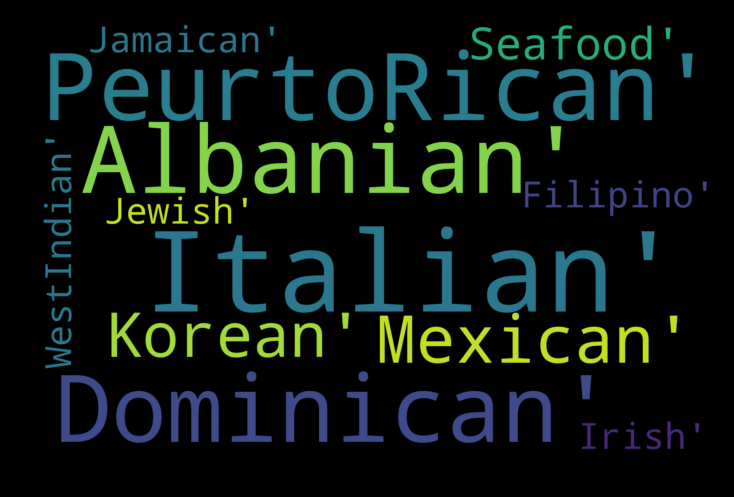

In [48]:
#text=t.loc[t['Borough'] == 'Bronx','Cuisine']
#h=pd.Series(text).value_counts()
df_Filtered_B=t[t['Borough'].str.contains('Bronx')]
df_Filtered_B.drop('Neighborhood',axis=1,inplace=True)
#count=df_Filtered_B['Cuisine'].value_counts()
#count.plot.bar()
#plt.title('Common Cuisines in Neighborhoods in Bronx', fontsize = 15)
#plt.xlabel('Cuisines', fontsize = 15)
#plt.show()

text = df_Filtered_B['Cuisine'].str.replace(' ', '').values
wordcloud = WordCloud(width = 3000,height = 2000,background_color = 'black').generate(str(text))
fig = plt.figure(figsize = (10, 10),facecolor = 'k',edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Cuisines in The Bronx')
plt.tight_layout(pad=0)
plt.show()

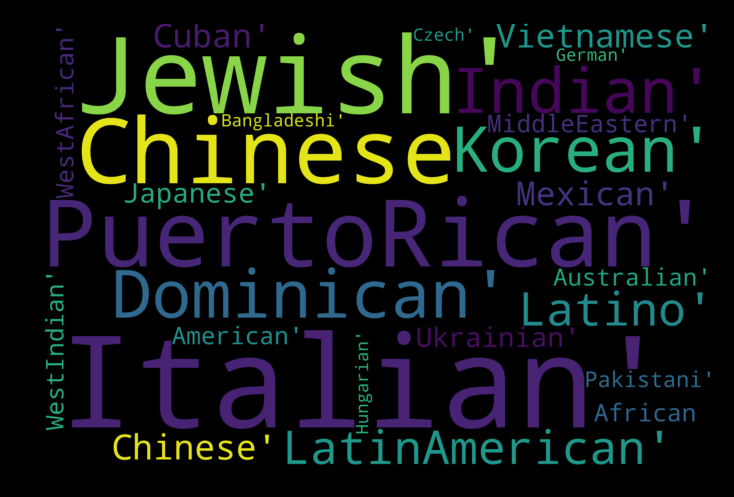

(0.0, 1.0, 0.0, 1.0)

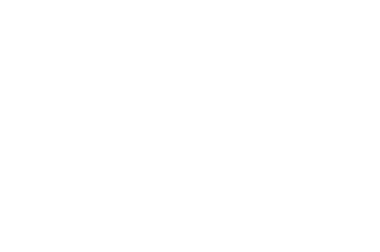

In [51]:
df_Filtered_M=t[t['Borough'].str.contains('Manhattan')]
df_Filtered_M.drop('Neighborhood',axis=1,inplace=True)

text = df_Filtered_M['Cuisine'].str.replace(' ', '').values
wordcloud = WordCloud(width = 3000,height = 2000,background_color = 'black').generate(str(text))
fig = plt.figure(figsize = (10, 10),facecolor = 'k',edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Cuisines in The Manhattan')
plt.tight_layout(pad=0)
plt.show()
plt.axis('off')


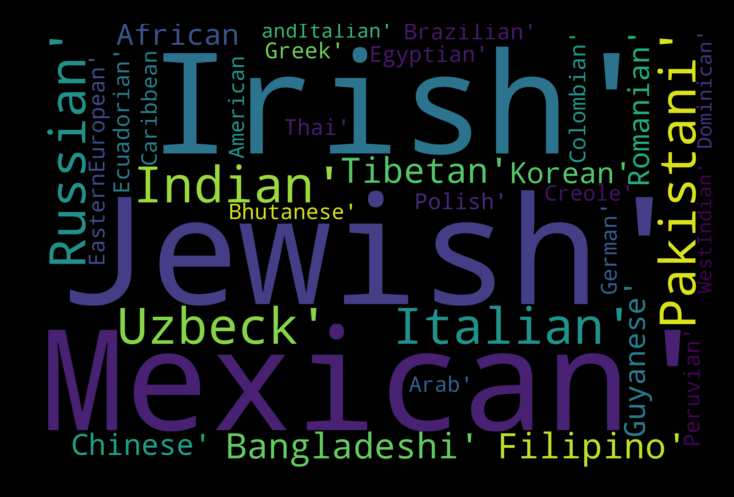

(0.0, 1.0, 0.0, 1.0)

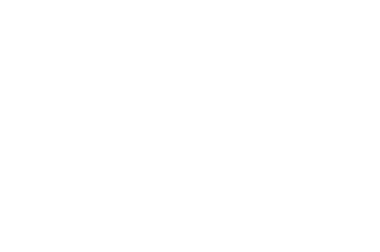

In [52]:
    df_Filtered_Q=t[t['Borough'].str.contains('Queens')]
    df_Filtered_Q.drop('Neighborhood',axis=1,inplace=True)
    #count=df_Filtered_Q['Cuisine'].value_counts()
    #count.plot.bar()
    #plt.title('Common Cuisines in Neighborhoods in Queens', fontsize = 15)
#plt.xlabel('Cuisines', fontsize = 15)
#plt.show()
text = df_Filtered_Q['Cuisine'].str.replace(' ', '').values
wordcloud = WordCloud(width = 3000,height = 2000,background_color = 'black').generate(str(text))
fig = plt.figure(figsize = (10, 10),facecolor = 'k',edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Cuisines in Queens')
plt.tight_layout(pad=0)
plt.show()
plt.axis('off')


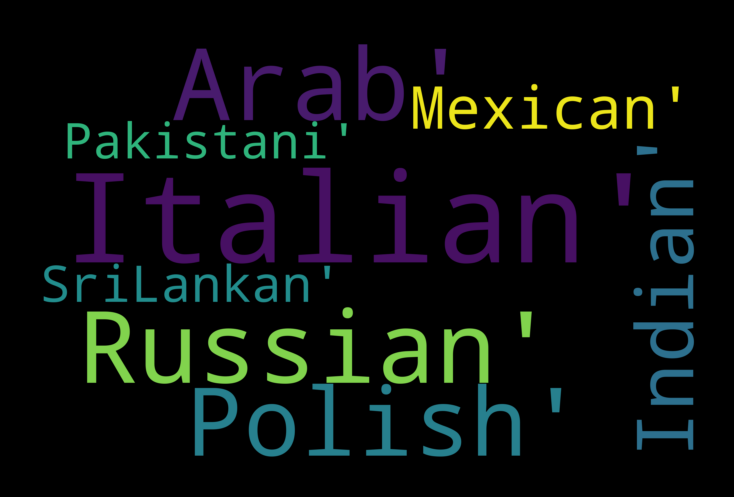

(0.0, 1.0, 0.0, 1.0)

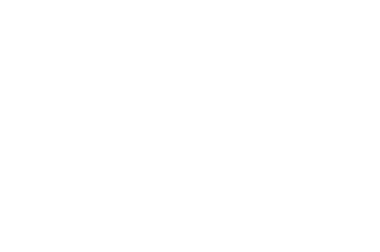

In [53]:
df_Filtered_S=t[t['Borough'].str.contains('Staten Island')]
df_Filtered_S.drop('Neighborhood',axis=1,inplace=True)
#count=df_Filtered_S['Cuisine'].value_counts()
#count.plot.bar()
#plt.title('Common Cuisines in Neighborhoods in Staten Island', fontsize = 15)
#plt.xlabel('Cuisines', fontsize = 15)
#plt.show()
text = df_Filtered_S['Cuisine'].str.replace(' ', '').values
wordcloud = WordCloud(width = 3000,height = 2000,background_color = 'black').generate(str(text))
fig = plt.figure(figsize = (10, 10),facecolor = 'k',edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Cuisines in Staten Island')
plt.tight_layout(pad=0)
plt.show()
plt.axis('off')


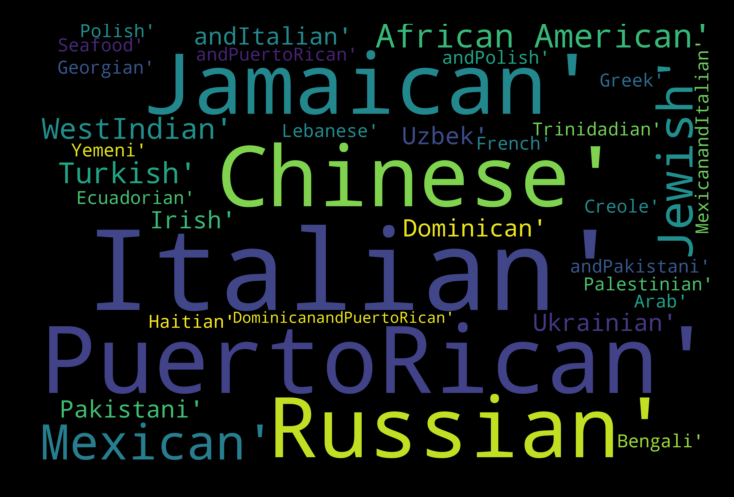

(0.0, 1.0, 0.0, 1.0)

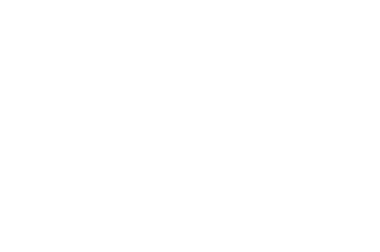

In [54]:
df_Filtered_Br=t[t['Borough'].str.contains('Brooklyn')]
df_Filtered_Br.drop('Neighborhood',axis=1,inplace=True)
#count=df_Filtered_Br['Cuisine'].value_counts()
#count.plot.bar()
#plt.title('Common Cuisines in Neighborhoods in Brooklyn', fontsize = 15)
#plt.xlabel('Cuisines', fontsize = 15)
#plt.show()
text = df_Filtered_Br['Cuisine'].str.replace(' ', '').values
wordcloud = WordCloud(width = 3000,height = 2000,background_color = 'black').generate(str(text))
fig = plt.figure(figsize = (10, 10),facecolor = 'k',edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Cuisines in Brooklyn')
plt.tight_layout(pad=0)
plt.show()
plt.axis('off')


### Let's explore the Boroughs further

In [104]:
CLIENT_ID = '15R1NDGE5SSRDYRD1B2AIAI4RC10AY3WCHLECOFUPGE1BPBJ' # your Foursquare ID
CLIENT_SECRET = '5LEEUN4QYBPMDU0HK31URNSJM1DXSZOISW42X0OIO5CHTKHM' # your Foursquare Secret
VERSION = '20191119' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 15R1NDGE5SSRDYRD1B2AIAI4RC10AY3WCHLECOFUPGE1BPBJ
CLIENT_SECRET:5LEEUN4QYBPMDU0HK31URNSJM1DXSZOISW42X0OIO5CHTKHM


#### Function on each Neighborhood to get nearby venues

In [14]:
def getNearbyVenues(boroughs,names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for b,name, lat, lng in zip(boroughs,names, latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(b,name,lat,lng,v['venue']['name'],v['venue']['location']['lat'],v['venue']['location']['lng'],v['venue']['id'],v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough','Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue ID',
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
all_venues = getNearbyVenues(boroughs=neighborhoods['Borough'],names=neighborhoods['Neighborhood'],latitudes=neighborhoods['Latitude'],longitudes=neighborhoods['Longitude'])


In [18]:
print("Total venues returned :",all_venues.size)

Total venues returned : 91566


#### Having a look at some of the venues returned

In [20]:
all_venues.head(10)

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category
0,Bronx,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,4c537892fd2ea593cb077a28,Dessert Shop
1,Bronx,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,4d6af9426107f04dedeb297a,Pharmacy
2,Bronx,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,4c783cef3badb1f7e4244b54,Ice Cream Shop
3,Bronx,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,4c81a91c51ada1cd87741510,Gas Station
4,Bronx,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,4c25c212f1272d7f836385c5,Donut Shop
5,Bronx,Wakefield,40.894705,-73.847201,SUBWAY,40.890656,-73.849192,4d33665fb6093704b80001e0,Sandwich Place
6,Bronx,Wakefield,40.894705,-73.847201,Walgreens,40.896687,-73.844850,5d5f5044d0ae1c0008f043c3,Pharmacy
7,Bronx,Wakefield,40.894705,-73.847201,Central Deli,40.896728,-73.844387,4f32458019836c91c7c734ff,Deli / Bodega
8,Bronx,Wakefield,40.894705,-73.847201,Koss Quick Wash,40.891281,-73.849904,5681717c498e9b9cf4d8c187,Laundromat
9,Bronx,Co-op City,40.874294,-73.829939,Dollar Tree,40.870125,-73.828989,4c9bde217c096dcbd07dbcd1,Discount Store


### Writing information obtained on Nearby venues to a .csv file for future reference as limited calls allowed with forsquare

### Insert Project Token

In [16]:
# The code was removed by Watson Studio for sharing.

#### Get project Details

In [17]:
print('Project Name: {0}'.format(project.get_name()))
print('Project Description: {0}'.format(project.get_description()))
print('Project Bucket Name: {0}'.format(project.get_project_bucket_name()))
print('Project Assets (Connections): {0}'.format(project.get_assets(asset_type='connection')))

Project Name: Capstone Project
Project Description: 
Project Bucket Name: capstoneproject-donotdelete-pr-keo4s9iy3sat3t
Project Assets (Connections): []


In [23]:
# Save dataframe as csv file to storage
project.save_data(data=all_venues.to_csv(index=False),file_name='nyvenues.csv',overwrite=True)


{'file_name': 'nyvenues.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'capstoneproject-donotdelete-pr-keo4s9iy3sat3t',
 'asset_id': 'cba38fdf-4166-4842-ae1c-94035102baaa'}

In [18]:
#Getting csv file and loading as pandas datafarme
ny_venues=pd.read_csv(project.get_file('nyvenues.csv'))
ny_venues.head(10)

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category
0,Bronx,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,4c537892fd2ea593cb077a28,Dessert Shop
1,Bronx,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,4d6af9426107f04dedeb297a,Pharmacy
2,Bronx,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,4c783cef3badb1f7e4244b54,Ice Cream Shop
3,Bronx,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,4c81a91c51ada1cd87741510,Gas Station
4,Bronx,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,4c25c212f1272d7f836385c5,Donut Shop
5,Bronx,Wakefield,40.894705,-73.847201,SUBWAY,40.890656,-73.849192,4d33665fb6093704b80001e0,Sandwich Place
6,Bronx,Wakefield,40.894705,-73.847201,Walgreens,40.896687,-73.844850,5d5f5044d0ae1c0008f043c3,Pharmacy
7,Bronx,Wakefield,40.894705,-73.847201,Central Deli,40.896728,-73.844387,4f32458019836c91c7c734ff,Deli / Bodega
8,Bronx,Wakefield,40.894705,-73.847201,Koss Quick Wash,40.891281,-73.849904,5681717c498e9b9cf4d8c187,Laundromat
9,Bronx,Co-op City,40.874294,-73.829939,Dollar Tree,40.870125,-73.828989,4c9bde217c096dcbd07dbcd1,Discount Store


#### Unique Categories from Venues

In [19]:
print('There are {} uniques categories.'.format(len(ny_venues['Venue Category'].unique())))

There are 428 uniques categories.


In [20]:
ny_res=ny_venues[ny_venues['Venue Category'].str.contains('Restaurant')]
ny_res.reset_index(inplace=True)

### Counting venues spread over New York Based on Category

In [21]:
ny_restaurants=ny_venues[ny_venues['Venue Category'].str.contains('Restaurant')]
category_res=ny_restaurants.groupby('Venue Category').count()
category_res.drop(['Neighborhood Latitude', 'Neighborhood Longitude','Neighborhood','Venue','Venue Latitude','Venue Longitude','Venue ID'],axis=1,inplace=True)
category_res.rename(columns={'Borough':'Count'},inplace=True)
category_res.sort_values(by=['Count'],ascending=False,inplace=True)
category_res.head(20)

,Count
Venue Category,
Italian Restaurant,310
Chinese Restaurant,207
American Restaurant,170
Mexican Restaurant,168
Sushi Restaurant,108
Japanese Restaurant,101
Fast Food Restaurant,94
Thai Restaurant,85
Caribbean Restaurant,84


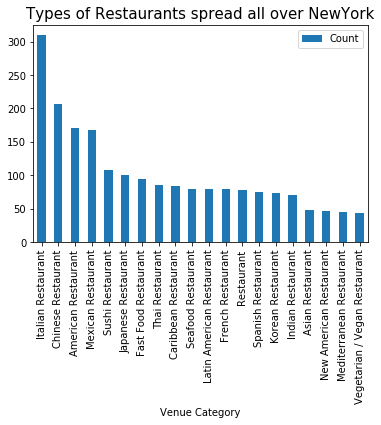

In [22]:
c=category_res.head(20)
c.plot.bar()
plt.title('Types of Restaurants spread all over NewYork', fontsize = 15)
plt.show()



### Analying Each Neighborhood

In [23]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_res[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_res['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,...,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Eastchester,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Eastchester,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Eastchester,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
ny_onehot.shape

(2541, 92)

In [25]:
ny_res_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()
ny_res_grouped

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,...,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Allerton,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
1,Annadale,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2,Arrochar,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,Arverne,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,Astoria,0.000000,0.000000,0.027027,0.000000,0.000000,0.000000,0.000000,0.000000,0.027027,...,0.0,0.000000,0.0,0.027027,0.000000,0.000000,0.0,0.027027,0.0,0.000000
5,Astoria Heights,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
6,Auburndale,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
7,Bath Beach,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.058824,0.0,0.000000,0.0,0.000000
8,Battery Park City,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
9,Bay Ridge,0.000000,0.000000,0.103448,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.068966,0.000000,0.000000,0.0,0.000000,0.0,0.034483


#### Printing each neighborhood along with the top 5 most common restaurants

In [26]:
num_top_venues = 5

for hood in ny_res_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ny_res_grouped[ny_res_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
                     venue  freq
0     Fast Food Restaurant  0.33
1       Spanish Restaurant  0.33
2       Chinese Restaurant  0.33
3        Afghan Restaurant  0.00
4  Scandinavian Restaurant  0.00


----Annadale----
                     venue  freq
0      American Restaurant  0.50
1               Restaurant  0.25
2         Sushi Restaurant  0.25
3        Afghan Restaurant  0.00
4  North Indian Restaurant  0.00


----Arrochar----
                       venue  freq
0         Italian Restaurant   0.4
1   Mediterranean Restaurant   0.2
2          Polish Restaurant   0.2
3  Middle Eastern Restaurant   0.2
4          Afghan Restaurant   0.0


----Arverne----
                     venue  freq
0          Thai Restaurant   1.0
1        Afghan Restaurant   0.0
2  New American Restaurant   0.0
3      Romanian Restaurant   0.0
4               Restaurant   0.0


----Astoria----
                       venue  freq
0  Middle Eastern Restaurant  0.14
1           Greek Restaurant  0.14


In [27]:
## function for sorting venues in descending order per neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Displaying top 10 Restaurants in each neighborhood

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ny_res_grouped['Neighborhood']

for ind in np.arange(ny_res_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_res_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(15)

,Neighborhood,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Allerton,Fast Food Restaurant,Chinese Restaurant,Spanish Restaurant,Vietnamese Restaurant,Egyptian Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
1,Annadale,American Restaurant,Sushi Restaurant,Restaurant,Italian Restaurant,Gluten-free Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
2,Arrochar,Italian Restaurant,Polish Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
3,Arverne,Thai Restaurant,Vietnamese Restaurant,Halal Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
4,Astoria,Greek Restaurant,Middle Eastern Restaurant,Seafood Restaurant,Mediterranean Restaurant,Latin American Restaurant,Italian Restaurant,Chinese Restaurant,Japanese Restaurant,Cajun / Creole Restaurant,Comfort Food Restaurant
5,Astoria Heights,Italian Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
6,Auburndale,Korean Restaurant,American Restaurant,Italian Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
7,Bath Beach,Chinese Restaurant,Italian Restaurant,Fast Food Restaurant,Kebab Restaurant,Sushi Restaurant,Restaurant,Dim Sum Restaurant,German Restaurant,Cantonese Restaurant,Peruvian Restaurant
8,Battery Park City,Italian Restaurant,Sushi Restaurant,American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Chinese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
9,Bay Ridge,Italian Restaurant,American Restaurant,Greek Restaurant,Thai Restaurant,Chinese Restaurant,Sushi Restaurant,Mediterranean Restaurant,Vietnamese Restaurant,Middle Eastern Restaurant,Fast Food Restaurant


### Gathering Detailed Information on Italian Restaurants in New York

In [29]:
italian_restaurants=ny_venues[ny_venues['Venue Category'].str.contains('Italian Restaurant')]

print("The number of Italian restaurants all over New York are :",italian_restaurants.shape)

The number of Italian restaurants all over New York are : (310, 9)


In [30]:
italian_restaurants.head()


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category
147,Bronx,Woodlawn,40.898273,-73.867315,Patrizia's Of Woodlawn,40.900638,-73.867724,511edb6de4b0d58346fd272d,Italian Restaurant
233,Bronx,Pelham Parkway,40.857413,-73.854756,Enzo's,40.854232,-73.854362,4bf96ae65317a593d837017f,Italian Restaurant
242,Bronx,Pelham Parkway,40.857413,-73.854756,Pasta Pasta,40.854788,-73.854929,4b47f069f964a5208c4426e3,Italian Restaurant
256,Bronx,City Island,40.847247,-73.786488,Artie's Steak and Seafood,40.849542,-73.787317,4514ed4df964a520e5391fe3,Italian Restaurant
643,Bronx,Throgs Neck,40.815109,-73.816350,Tosca Marquee,40.819222,-73.817601,4d4456d93616b60c953fe3c2,Italian Restaurant


In [31]:
italian_restaurants.reset_index(inplace=True)

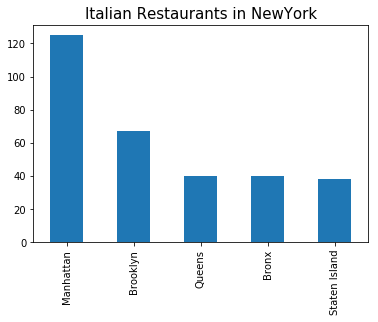

In [32]:
count=italian_restaurants['Borough'].value_counts()
count.plot.bar()
plt.title('Italian Restaurants in NewYork', fontsize = 15)
plt.show()


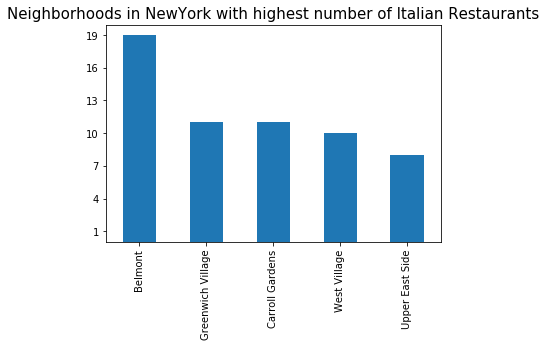

In [33]:
countn=italian_restaurants['Neighborhood'].value_counts()
c=countn.head()
c.plot.bar()
plt.yticks(range(1,21,3))
plt.title('Neighborhoods in NewYork with highest number of Italian Restaurants', fontsize = 15)
plt.show()


In [34]:
# create map of Italian Restaurants in New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(italian_restaurants['Neighborhood Latitude'], italian_restaurants['Neighborhood Longitude'], italian_restaurants['Borough'], italian_restaurants['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Gathering detailed information on Indian Restaurants in New York

In [35]:
indian_restaurants=ny_venues[ny_venues['Venue Category'].str.contains('Indian Restaurant')]

print("The number of Indian restaurants all over New York are :",indian_restaurants.shape)

The number of Indian restaurants all over New York are : (72, 9)


In [36]:
indian_restaurants.reset_index(inplace=True)
indian_restaurants.head(10)

,index,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category
0,148,Bronx,Woodlawn,40.898273,-73.867315,Curry Spot,40.897625,-73.867147,4c0448d9310fc9b6bf1dc761,Indian Restaurant
1,1049,Bronx,Unionport,40.829774,-73.850535,Melanies Roti Bar And Grill,40.833293,-73.851040,4c194631838020a13e78e561,Indian Restaurant
2,1112,Brooklyn,Bay Ridge,40.625801,-74.030621,Bombay Grill,40.622371,-74.031799,545835a1498e820edc6f636f,Indian Restaurant
3,1308,Brooklyn,Greenpoint,40.730201,-73.954241,Agra Taj Mahal,40.733321,-73.954928,51a5445c498ee0f182370cb2,Indian Restaurant
4,1590,Brooklyn,Prospect Heights,40.676822,-73.964859,Nimbooda,40.678277,-73.963957,56e75fc9498e802e6ae2a716,North Indian Restaurant
5,1745,Brooklyn,Bushwick,40.698116,-73.925258,Agra Heights,40.698094,-73.921355,5169f5c4e4b0c7fcb77a0f3c,Indian Restaurant
6,1843,Brooklyn,Brooklyn Heights,40.695864,-73.993782,Curry Heights,40.693572,-73.992265,4b8ffc16f964a520246e33e3,Indian Restaurant
7,1873,Brooklyn,Brooklyn Heights,40.695864,-73.993782,Asya Indian Restaurant,40.699607,-73.992110,506a2625498e3c434686abbc,Indian Restaurant
8,2141,Brooklyn,Gowanus,40.673931,-73.994441,Kanan's Indian Restaurant,40.671891,-73.990940,52f18573498ec2c34e830ffd,Indian Restaurant
9,2221,Brooklyn,Fort Greene,40.688527,-73.972906,Dosa Royale,40.689466,-73.968704,57596dad498e732300496b23,Indian Restaurant


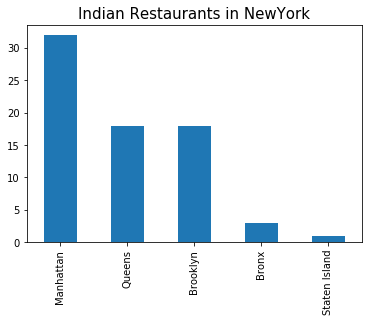

In [37]:
count=indian_restaurants['Borough'].value_counts()
count.plot.bar()
plt.title('Indian Restaurants in NewYork', fontsize = 15)
plt.show()

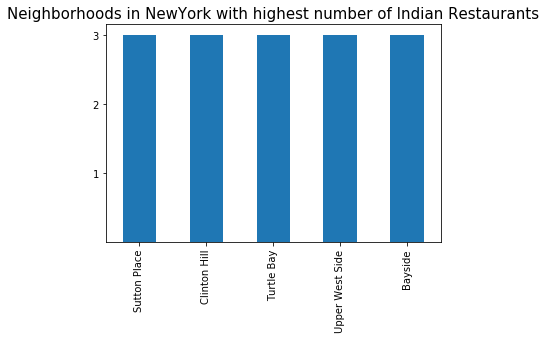

In [38]:
countn=indian_restaurants['Neighborhood'].value_counts()
c=countn.head()
c.plot.bar()
plt.yticks(range(1,4))
plt.title('Neighborhoods in NewYork with highest number of Indian Restaurants', fontsize = 15)
plt.show()


In [39]:
# create map of Indian Restaurants in New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(indian_restaurants['Neighborhood Latitude'], indian_restaurants['Neighborhood Longitude'], indian_restaurants['Borough'], indian_restaurants['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Gathering Information on Venues such as Ratings and Likes 

In [109]:
def get_venue_details(venue_id):
    venue_details=[]
    
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(venue_id,CLIENT_ID,CLIENT_SECRET,VERSION)
        # make the GET request
    results = requests.get(url).json()
    data=results['response']['venue']
        #return only relevant information for each nearby venue
    venue_details.append([venue_id,data['name'],data['rating'],data['likes']['count']])
    
       
    
    #venue_stats = pd.DataFrame([item1 for venue_details in venues_details for item1 in venue_details])
    column_names = ['Borough','Neighborhood','Venue ID','Venue Name','Venue Rating','Venue Likes']
    venue_stats = pd.DataFrame(venue_details,columns=column_names)
    return(venue_stats)

In [121]:
fetch_details.values.tolist()

[['Bronx',
  'Throgs Neck',
  '4d4456d93616b60c953fe3c2',
  'Tosca Marquee',
  6.6,
  19]]

### Clustering Neighborhoods

In [40]:
# set number of clusters
kclusters = 4

ny_grouped_clustering = ny_res_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 1, 3, 3, 1, 3, 3, 3, 3], dtype=int32)

In [41]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ny_merged = ny_restaurants

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ny_merged = ny_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ny_merged.head() # check the last columns!

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
15,Bronx,Co-op City,40.874294,-73.829939,Arby's,40.870280,-73.828611,5bc797c82d2fd9002c1b3ec6,Fast Food Restaurant,0,Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
17,Bronx,Co-op City,40.874294,-73.829939,Townhouse Restaurant,40.876086,-73.828868,4be2b79d660ec9284d04ca3b,Restaurant,0,Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
26,Bronx,Eastchester,40.887556,-73.827806,Fish & Ting,40.885656,-73.829197,515cc20ce4b0deb133b8e89b,Caribbean Restaurant,2,Caribbean Restaurant,Seafood Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
29,Bronx,Eastchester,40.887556,-73.827806,Dyre Fish Market,40.889318,-73.831453,4bfdd3dfb68d0f47fa6fe957,Seafood Restaurant,2,Caribbean Restaurant,Seafood Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
32,Bronx,Eastchester,40.887556,-73.827806,Golden Krust Caribbean Restaurant,40.888488,-73.831083,4c632fbaeb82d13a3c5007d6,Caribbean Restaurant,2,Caribbean Restaurant,Seafood Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant


### Visualizing the Clusters

In [133]:
# create map
map_clusters = folium.Map(location=[ 40.7127281, -74.0060152], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighborhood,category, cluster in zip(ny_merged['Neighborhood Latitude'], ny_merged['Neighborhood Longitude'], ny_merged['Neighborhood'], ny_merged['Venue Category'], ny_merged['Cluster Labels']):

    label = folium.Popup(str(poi)+ ' : ' + str(category) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


### Examining Clusters

### Cluster 1

In [43]:
ny_merged.loc[ny_merged['Cluster Labels'] == 0, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

,Neighborhood,Venue Latitude,Venue Longitude,Venue ID,Venue Category,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
15,Co-op City,40.870280,-73.828611,5bc797c82d2fd9002c1b3ec6,Fast Food Restaurant,0,Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
17,Co-op City,40.876086,-73.828868,4be2b79d660ec9284d04ca3b,Restaurant,0,Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
321,University Heights,40.853871,-73.908421,4c2f8b1b7cc0c9b6a1eaeb9a,African Restaurant,0,Fast Food Restaurant,Chinese Restaurant,African Restaurant,Latin American Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
323,University Heights,40.853744,-73.907966,4bcf761b41b9ef3b547af8e5,Latin American Restaurant,0,Fast Food Restaurant,Chinese Restaurant,African Restaurant,Latin American Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
332,University Heights,40.854336,-73.907281,4c20227fbd9d9521cd66983f,Fast Food Restaurant,0,Fast Food Restaurant,Chinese Restaurant,African Restaurant,Latin American Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
333,University Heights,40.853515,-73.907294,5ca15aecb3c961002c0aedc4,Fast Food Restaurant,0,Fast Food Restaurant,Chinese Restaurant,African Restaurant,Latin American Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
339,University Heights,40.852172,-73.909454,4f32b5d419836c91c7f21e76,Chinese Restaurant,0,Fast Food Restaurant,Chinese Restaurant,African Restaurant,Latin American Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
340,University Heights,40.852306,-73.907705,4e4cfe91bd413c4cc66dd626,Chinese Restaurant,0,Fast Food Restaurant,Chinese Restaurant,African Restaurant,Latin American Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
343,Morris Heights,40.846042,-73.919716,4e39863dae60f589a5dc0dcb,Spanish Restaurant,0,Latin American Restaurant,Spanish Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
349,Morris Heights,40.844938,-73.920950,4bf95916508c0f471c443f31,Latin American Restaurant,0,Latin American Restaurant,Spanish Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant


### Cluster 2

In [44]:
ny_merged.loc[ny_merged['Cluster Labels'] == 1, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

,Neighborhood,Venue Latitude,Venue Longitude,Venue ID,Venue Category,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
147,Woodlawn,40.900638,-73.867724,511edb6de4b0d58346fd272d,Italian Restaurant,1,Italian Restaurant,Indian Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
148,Woodlawn,40.897625,-73.867147,4c0448d9310fc9b6bf1dc761,Indian Restaurant,1,Italian Restaurant,Indian Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
648,Country Club,40.846025,-73.820974,4be35e62b02ec9b6b66b4fc0,Italian Restaurant,1,Italian Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
739,Morris Park,40.849313,-73.853536,4b10591af964a5205f6e23e3,Italian Restaurant,1,Italian Restaurant,Arepa Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
744,Morris Park,40.848039,-73.856182,546cd226498e19b653c19e69,Arepa Restaurant,1,Italian Restaurant,Arepa Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
760,Belmont,40.855882,-73.887166,4acf80aef964a52025d420e3,Italian Restaurant,1,Italian Restaurant,Mexican Restaurant,Eastern European Restaurant,Fast Food Restaurant,Spanish Restaurant,Japanese Restaurant,American Restaurant,Indian Restaurant,Hunan Restaurant,English Restaurant
764,Belmont,40.857412,-73.886468,4af71916f964a520cf0522e3,Italian Restaurant,1,Italian Restaurant,Mexican Restaurant,Eastern European Restaurant,Fast Food Restaurant,Spanish Restaurant,Japanese Restaurant,American Restaurant,Indian Restaurant,Hunan Restaurant,English Restaurant
774,Belmont,40.854844,-73.887908,59050f51b23dfa5f6649e678,Italian Restaurant,1,Italian Restaurant,Mexican Restaurant,Eastern European Restaurant,Fast Food Restaurant,Spanish Restaurant,Japanese Restaurant,American Restaurant,Indian Restaurant,Hunan Restaurant,English Restaurant
776,Belmont,40.854145,-73.888776,4bb6470cef159c7465b275f7,Italian Restaurant,1,Italian Restaurant,Mexican Restaurant,Eastern European Restaurant,Fast Food Restaurant,Spanish Restaurant,Japanese Restaurant,American Restaurant,Indian Restaurant,Hunan Restaurant,English Restaurant
781,Belmont,40.854215,-73.888765,4aa425bef964a5208e4520e3,Italian Restaurant,1,Italian Restaurant,Mexican Restaurant,Eastern European Restaurant,Fast Food Restaurant,Spanish Restaurant,Japanese Restaurant,American Restaurant,Indian Restaurant,Hunan Restaurant,English Restaurant


### Cluster 3

In [45]:
ny_merged.loc[ny_merged['Cluster Labels'] == 2, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

,Neighborhood,Venue Latitude,Venue Longitude,Venue ID,Venue Category,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
26,Eastchester,40.885656,-73.829197,515cc20ce4b0deb133b8e89b,Caribbean Restaurant,2,Caribbean Restaurant,Seafood Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
29,Eastchester,40.889318,-73.831453,4bfdd3dfb68d0f47fa6fe957,Seafood Restaurant,2,Caribbean Restaurant,Seafood Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
32,Eastchester,40.888488,-73.831083,4c632fbaeb82d13a3c5007d6,Caribbean Restaurant,2,Caribbean Restaurant,Seafood Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
34,Eastchester,40.885636,-73.826840,4c406f2e6c1a9521a042b96a,Fast Food Restaurant,2,Caribbean Restaurant,Seafood Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
35,Eastchester,40.888249,-73.831661,4dbf84a24df0f8fd6b88c9b6,Caribbean Restaurant,2,Caribbean Restaurant,Seafood Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
43,Eastchester,40.888785,-73.831226,4dabc3dc93a04642f09ccabd,Chinese Restaurant,2,Caribbean Restaurant,Seafood Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
205,Williamsbridge,40.884143,-73.856449,4ca7451314c337042fadc73b,Caribbean Restaurant,2,Caribbean Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
206,Williamsbridge,40.878756,-73.861422,4d0d13795c46a09322620cb4,Caribbean Restaurant,2,Caribbean Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
207,Williamsbridge,40.883148,-73.862693,4c66b99febfcb71314061327,Fast Food Restaurant,2,Caribbean Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
722,Van Nest,40.847338,-73.866632,4fcfeb586b748e9d19eac30d,Middle Eastern Restaurant,2,Middle Eastern Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant


### Cluster 4

In [46]:
ny_merged.loc[ny_merged['Cluster Labels'] == 3, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]

,Neighborhood,Venue Latitude,Venue Longitude,Venue ID,Venue Category,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
58,Kingsbridge,40.883742,-73.901857,55297008498e9286460da191,Latin American Restaurant,3,Mexican Restaurant,Latin American Restaurant,Spanish Restaurant,Seafood Restaurant,Asian Restaurant,Fast Food Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant
60,Kingsbridge,40.879338,-73.904457,4bd8e98811dcc928f865f833,Caribbean Restaurant,3,Mexican Restaurant,Latin American Restaurant,Spanish Restaurant,Seafood Restaurant,Asian Restaurant,Fast Food Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant
68,Kingsbridge,40.879687,-73.906257,5217dd2811d2d06ccafb77d3,Mexican Restaurant,3,Mexican Restaurant,Latin American Restaurant,Spanish Restaurant,Seafood Restaurant,Asian Restaurant,Fast Food Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant
70,Kingsbridge,40.879330,-73.904597,4ca785a597c8a1cd7e577ba5,Spanish Restaurant,3,Mexican Restaurant,Latin American Restaurant,Spanish Restaurant,Seafood Restaurant,Asian Restaurant,Fast Food Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant
72,Kingsbridge,40.878252,-73.902936,4ce81d330f196dcb5d2b43ae,Mexican Restaurant,3,Mexican Restaurant,Latin American Restaurant,Spanish Restaurant,Seafood Restaurant,Asian Restaurant,Fast Food Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant
74,Kingsbridge,40.884566,-73.900474,553d5376498e322eb4d37a1b,Mexican Restaurant,3,Mexican Restaurant,Latin American Restaurant,Spanish Restaurant,Seafood Restaurant,Asian Restaurant,Fast Food Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant
79,Kingsbridge,40.880006,-73.904157,50ea5611e4b044bdeead3ade,Spanish Restaurant,3,Mexican Restaurant,Latin American Restaurant,Spanish Restaurant,Seafood Restaurant,Asian Restaurant,Fast Food Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant
84,Kingsbridge,40.877885,-73.905873,4b9c9c6af964a520b27236e3,Seafood Restaurant,3,Mexican Restaurant,Latin American Restaurant,Spanish Restaurant,Seafood Restaurant,Asian Restaurant,Fast Food Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant
88,Kingsbridge,40.880706,-73.902687,4e8b34c561afcc24d9a236ca,Latin American Restaurant,3,Mexican Restaurant,Latin American Restaurant,Spanish Restaurant,Seafood Restaurant,Asian Restaurant,Fast Food Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant
113,Kingsbridge,40.882770,-73.901816,5cf0563bd807ee002cc2e793,Asian Restaurant,3,Mexican Restaurant,Latin American Restaurant,Spanish Restaurant,Seafood Restaurant,Asian Restaurant,Fast Food Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant
